# Network intrusion detection
The data used here is NSL-KDD data set, an updated version of KDD Cup 99 data
## Load data

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
columns = ['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'label',
 'difficulty_level']

In [4]:
train = pd.read_csv('KDDTrain+.txt', sep=',', header=None, names=columns)
test = pd.read_csv('KDDTest+.txt', sep=',', header=None, names=columns)

In [5]:
print(train.shape, test.shape)

(125973, 43) (22544, 43)


In [6]:
pd.set_option('display.max_columns', 0)
train.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,neptune,19


## Visualize feature distributions

In [7]:
# exclude category features and labels

temp = train.drop(['protocol_type', 'service', 'flag', 'label', 'difficulty_level'], axis=1)

C:\Anaconda2\envs\py36\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Anaconda2\envs\py36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


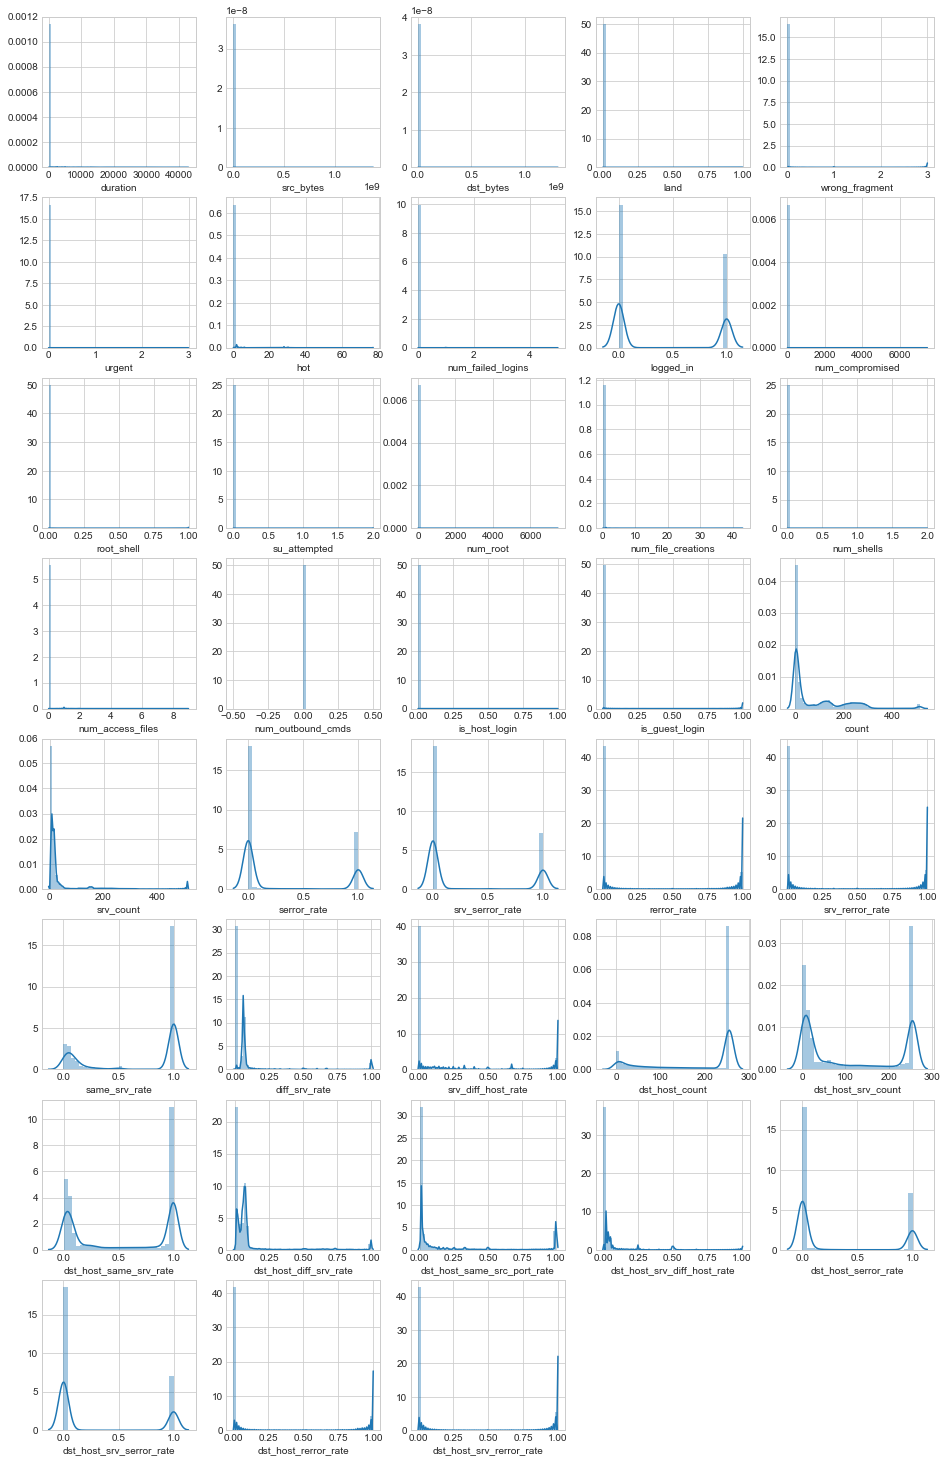

In [8]:
# plot numerical features distribution

fig = plt.figure(figsize=(16, 26))
sns.set_style('whitegrid')

for k, v in enumerate(list(temp.columns)):
    ax = fig.add_subplot(8, 5, 1+k)
    sns.distplot(temp[v], ax=ax)
#fig.tight_layout()

In [9]:
# Label encoding category features

from sklearn import preprocessing
temp_cat = train[['protocol_type', 'service', 'flag']].apply(preprocessing.LabelEncoder().fit_transform)

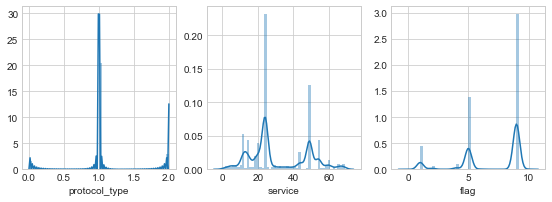

In [10]:
# plot category features distribution

fig = plt.figure(figsize=(16, 3))
sns.set_style('whitegrid')

for k, v in enumerate(list(temp_cat.columns)):
    ax = fig.add_subplot(1, 5, 1+k)
    sns.distplot(temp_cat[v], ax=ax)

## Data preprocessing

In [11]:
# https://www.researchgate.net/publication/267558979_Efficient_Classifier_for_R2L_and_U2R_Attacks
# https://ll.mit.edu/ideval/docs/attackDB.html

attack_category = {
                   'normal': ['normal'],
                   'probe': ['satan', 'mscan', 'portsweep', 'saint', 'ipsweep', 'nmap'],
                   'dos': ['smurf', 'neptune', 'mailbomb', 'back', 'apache2', 'processtable', 'pod', 'teardrop', 'land', 
                           'udpstorm'],
                   'u2r': ['buffer_overflow', 'ps', 'rootkit', 'xterm', 'sqlattack', 'loadmodule', 'perl'],
                   'r2l': ['snmpgetattack', 'guess_passwd', 'snmpguess', 'warezmaster', 'httptunnel', 'multihop', 'named', 
                           'sendmail', 'xlock', 'xsnoop', 'ftp_write', 'worm', 'phf', 'imap', 'warezclient', 'spy'],
                   }

In [12]:
# transform attack type to 1 of 4 attack categories: probe, denial_of_service, user_to_root, remote_to_local

def type_category(label):
    for k, v in attack_category.items():
        if label in v:
            return k

In [13]:
# some features are skewed here, should take log before scaling

train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [14]:
def preprocess(df):
    
    # exclude unuseful features and label
    X = df.drop(['num_outbound_cmds', 'label', 'difficulty_level'], axis=1)
    
    # take log on skewed features
    skewed_features = ['duration', 'src_bytes', 'dst_bytes', 'num_compromised', 'num_root', 'count', 'srv_count', 
                       'dst_host_count', 'dst_host_srv_count']    
    X[skewed_features] = X[skewed_features].apply(lambda x: np.log(x + 1))
    
    # get dummy for category features
    X = pd.get_dummies(X, columns=['protocol_type', 'service', 'flag'])
        
    # map label/attack type to category
    y = df.label.apply(type_category)
    
    return X, y

In [15]:
X, y = preprocess(train)
print(X.shape, y.shape)

(125973, 121) (125973,)


In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## PCA for visualization

In [17]:
from sklearn.decomposition import PCA

### 2D plot

In [18]:
pca = PCA(n_components=2)

In [19]:
X_pca = pca.fit_transform(X_scaled)

In [20]:
# print cumulated explained_variance_ratio

def print_var(pca):
    print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

In [21]:
print_var(pca)

[ 40.97  56.84]


In [22]:
pca_2d = pd.DataFrame(data=X_pca, columns=['PCA_1', 'PCA_2']).join(y)
pca_2d.head()

,PCA_1,PCA_2,label
0,-0.456735,0.150778,normal
1,-0.135281,0.589979,normal
2,2.038031,-0.420451,dos
3,-1.105082,-0.565179,normal
4,-1.161549,-0.479418,normal


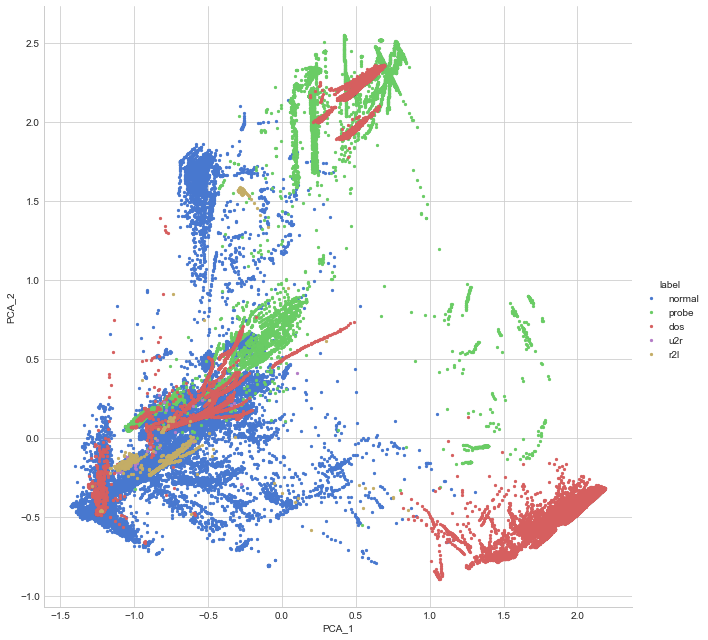

In [23]:
fig = sns.FacetGrid(data=pca_2d, hue='label', aspect=1, size=9, palette='muted', 
                    hue_order=['normal', 'probe', 'dos', 'u2r', 'r2l'])
fig.map(plt.scatter, 'PCA_1', 'PCA_2', s=5).add_legend()

### 3D plot

In [24]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [25]:
print_var(pca)

[ 40.97  56.84  67.9 ]


In [26]:
pca_3d = pd.DataFrame(data=X_pca, columns=['PCA_1', 'PCA_2', 'PCA_3']).join(y)
#pca_3d['label_num'] = pca_3d.label.map({'normal':0, 'probe':1, 'dos':2, 'u2r':3, 'r2l':4})
pca_3d.head()

,PCA_1,PCA_2,PCA_3,label
0,-0.456735,0.150778,0.277888,normal
1,-0.135281,0.589979,1.348517,normal
2,2.038031,-0.420451,-0.025162,dos
3,-1.105082,-0.565179,-0.598271,normal
4,-1.161549,-0.479418,-0.525432,normal


In [27]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

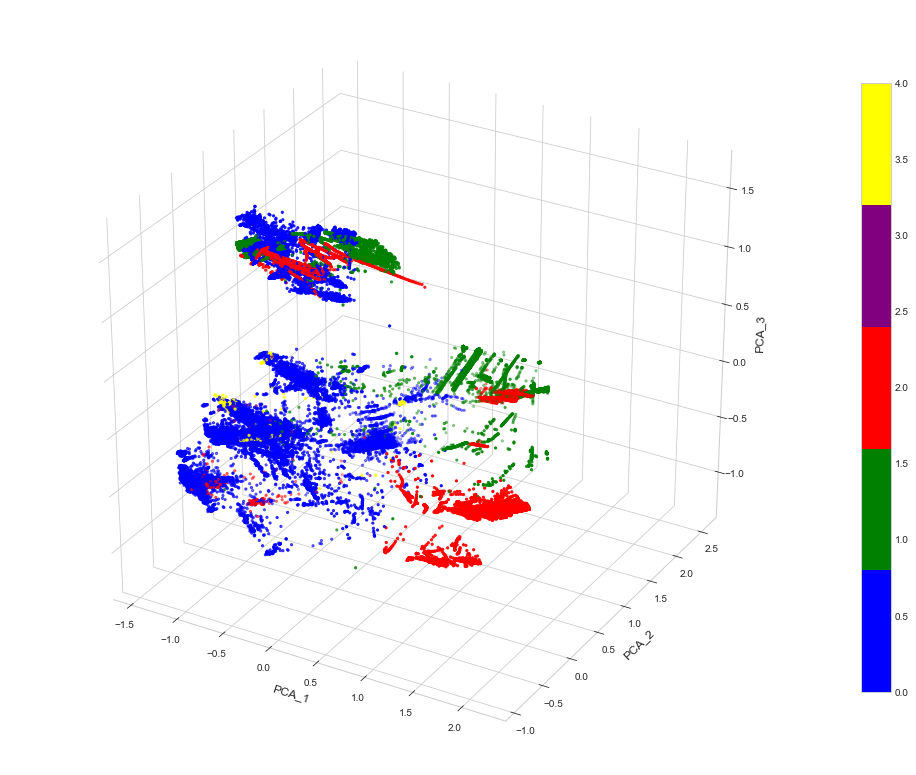

In [28]:
fig = plt.figure(figsize=(18, 14))
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel('PCA_1', fontsize = 12)
ax.set_ylabel('PCA_2', fontsize = 12)
ax.set_zlabel('PCA_3', fontsize = 12)

color = pca_3d.label.map({'normal':0.0, 'probe':1.0, 'dos':2.0, 'u2r':3.0, 'r2l':4.0})

# Display order: Normal, Probe, Dos, U2R, R2L
#my_colors = ["#0000ff", "#008000", "#ff0000", "#800080", "#ffff00"]
#my_cmap = ListedColormap(sns.color_palette(my_colors).as_hex())

my_colors = ['blue', 'green', 'red', 'purple', 'yellow']
my_cmap = ListedColormap(my_colors)

p = ax.scatter(pca_3d.PCA_1, pca_3d.PCA_2, pca_3d.PCA_3, marker='o', s=5, c=color, cmap=my_cmap)
fig.colorbar(p, shrink=0.8)

#fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
#fig.tight_layout()

#cb.set_ticks(loc)
#cb.set_ticklabels(['normal','probe','dos','u2r','r2l'])

## Modeling

In [29]:
X_test, y_test = preprocess(test)

In [30]:
print(X.shape, y.shape, X_test.shape, y_test.shape)

(125973, 121) (125973,) (22544, 115) (22544,)


In [31]:
print(train.service.nunique(), test.service.nunique())

70 64


In [32]:
X_test = X_test.T.reindex(X.columns).T.fillna(0)

In [33]:
print(X.shape, X_test.shape)

(125973, 121) (22544, 121)


In [34]:
X_test_scaled = scaler.transform(X_test)

In [35]:
category_label = {'normal':0, 'probe':1, 'dos':2, 'u2r':3, 'r2l':4}

y = y.map(category_label).astype('int')
y_test = y_test.map(category_label).astype('int')

### MLP

In [36]:
from keras.utils import to_categorical

# one-hot encode the labels
num_classes = y.nunique()
y_cat = to_categorical(y, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

Using TensorFlow backend.


In [61]:
# break training set into training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=1)

# print number of training, validation, and test samples
print(x_train.shape[0], 'Train samples')
print(x_valid.shape[0], 'Validation samples')
print(X_test_scaled.shape[0], 'Test samples')

100778 Train samples
25195 Validation samples
22544 Test samples


In [62]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# define the model
model = Sequential()

model.add(Dense(2560, input_dim=121, use_bias=True, activation='relu'))
#model.add(Dropout(0.1))
#model.add(Dense(128, use_bias=True, activation='relu'))
#model.add(Dropout(0.1))
#model.add(Dense(64, use_bias=True, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(num_classes, use_bias=True, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2560)              312320    
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 12805     
Total params: 325,125
Trainable params: 325,125
Non-trainable params: 0
_________________________________________________________________


In [63]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
from keras.callbacks import ModelCheckpoint  
import h5py

# train the model
checkpointer = ModelCheckpoint(filepath='MLP.weights.best.hdf5', verbose=1, save_best_only=True)
model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), callbacks=[checkpointer], verbose=2, shuffle=True)

Train on 100778 samples, validate on 25195 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 0.01668, saving model to MLP.weights.best.hdf5
24s - loss: 0.0377 - acc: 0.9890 - val_loss: 0.0167 - val_acc: 0.9955
Epoch 2/20
Epoch 00001: val_loss improved from 0.01668 to 0.01119, saving model to MLP.weights.best.hdf5
25s - loss: 0.0154 - acc: 0.9956 - val_loss: 0.0112 - val_acc: 0.9965
Epoch 3/20
Epoch 00002: val_loss improved from 0.01119 to 0.01035, saving model to MLP.weights.best.hdf5
24s - loss: 0.0114 - acc: 0.9965 - val_loss: 0.0104 - val_acc: 0.9970
Epoch 4/20
Epoch 00003: val_loss improved from 0.01035 to 0.00865, saving model to MLP.weights.best.hdf5
25s - loss: 0.0101 - acc: 0.9969 - val_loss: 0.0087 - val_acc: 0.9971
Epoch 5/20
Epoch 00004: val_loss did not improve
24s - loss: 0.0086 - acc: 0.9973 - val_loss: 0.0089 - val_acc: 0.9966
Epoch 6/20
Epoch 00005: val_loss improved from 0.00865 to 0.00666, saving model to MLP.weights.best.hdf5
24s - loss: 0.0087 - acc: 0.9

In [65]:
# load the weights that yielded the best validation accuracy
model.load_weights('MLP.weights.best.hdf5')

In [66]:
# evaluate and print test accuracy
score = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.807842441448


In [67]:
preds = model.predict_classes(X_test_scaled)

21856/22544 [============================>.] - ETA: 0s

In [68]:
from pandas_ml import ConfusionMatrix

cm = ConfusionMatrix(y_test, preds)
cm

Predicted      0     1     2   3    4  __all__
Actual                                        
0           9428   202    72   6    3     9711
1            459  1756   166   0   40     2421
2           1053    48  6266   0   91     7458
3             42     0     0  19    6       67
4           2119    18     0   7  743     2887
__all__    13101  2024  6504  32  883    22544

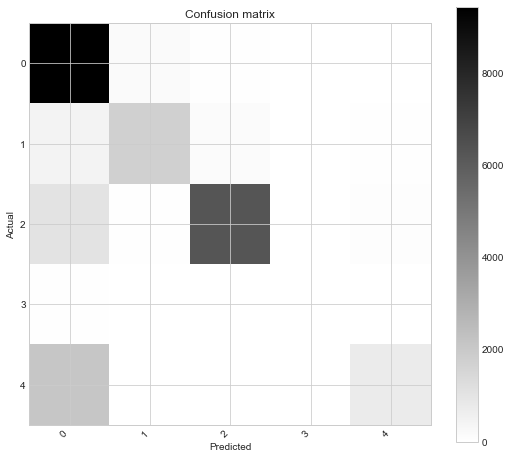

In [75]:
sns.set_style('whitegrid')
cm.plot()

In [76]:
cm.classification_report

,precision,recall,F1_score,support
Classes,,,,
0,0.71964,0.970858,0.826583,9711
1,0.867589,0.72532,0.790101,2421
2,0.963407,0.840172,0.897579,7458
3,0.59375,0.283582,0.383838,67
4,0.84145,0.257361,0.394164,2887
__avg / total__,0.831396,0.807842,0.78946,22544


### Dummy classifier

In [47]:
from sklearn.dummy import DummyClassifier

In [48]:
dummy = DummyClassifier(random_state=1, strategy='stratified')

In [49]:
dummy.fit(X, y)

DummyClassifier(constant=None, random_state=1, strategy='stratified')

In [50]:
dummy.score(X_test, y_test)

0.35982966643009229

In [51]:
preds_dummy = dummy.predict(X_test)

In [52]:
cm = ConfusionMatrix(y_test, preds_dummy)
cm

Predicted      0     1     2   3    4  __all__
Actual                                        
0           5156   870  3585   7   93     9711
1           1357   231   817   0   16     2421
2           3967   723  2697   6   65     7458
3             31    10    23   0    3       67
4           1577   273  1008   1   28     2887
__all__    12088  2107  8130  14  205    22544

In [53]:
cm.classification_report

,precision,recall,F1_score,support
Classes,,,,
0,0.426539,0.530944,0.473049,9711
1,0.109635,0.0954151,0.102032,2421
2,0.331734,0.361625,0.346035,7458
3,0,0,0,67
4,0.136585,0.00969865,0.0181113,2887
__avg / total__,0.322744,0.35983,0.331521,22544


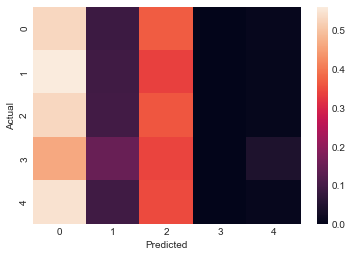

In [54]:
cm.plot(backend='seaborn', normalized=True)

### KNN

In [161]:
# PCA for feature reduction

pca = PCA(n_components=30)
X_reduced = pca.fit_transform(X_scaled)

In [162]:
print_var(pca)

[ 40.97  56.84  67.9   72.76  76.93  79.75  81.93  84.01  85.62  86.9
  87.87  88.71  89.49  90.12  90.71  91.21  91.67  92.11  92.5   92.86
  93.18  93.45  93.71  93.94  94.15  94.33  94.51  94.67  94.83  94.98]


In [163]:
X_test_reduced = pca.transform(X_test_scaled)

In [164]:
print(X_reduced.shape, X_test_reduced.shape)

(125973, 30) (22544, 30)


In [165]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [166]:
def knn_test(K):
    for k in K:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_reduced, y)
        preds_knn = knn.predict(X_test_reduced)
        score = accuracy_score(y_test, preds_knn)
        print(k, score)

knn_test(range(1,11,1))

1 0.759359474805
2 0.749201561391
3 0.762730660043
4 0.759758694109
5 0.762375798439
6 0.759137686302
7 0.761355571327
8 0.760024840312
9 0.761000709723
10 0.758339247693


In [167]:
# choose k = 3

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_reduced, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [168]:
preds_knn = knn.predict(X_test_reduced)
accuracy_score(y_test, preds_knn)

0.76273066004258339

In [169]:
cm_knn = ConfusionMatrix(y_test, preds_knn)
cm_knn

Predicted      0     1     2  3    4  __all__
Actual                                       
0           9006   642    59  3    1     9711
1            363  1853   168  0   37     2421
2           1310    57  6091  0    0     7458
3             57     0     0  5    5       67
4           2634    10     3  0  240     2887
__all__    13370  2562  6321  8  283    22544

In [170]:
cm_knn.classification_report

,precision,recall,F1_score,support
Classes,,,,
0,0.673598,0.927402,0.780382,9711
1,0.723263,0.765386,0.743729,2421
2,0.963613,0.816707,0.884099,7458
3,0.625,0.0746269,0.133333,67
4,0.848057,0.0831313,0.15142,2887
__avg / total__,0.797071,0.762731,0.728289,22544


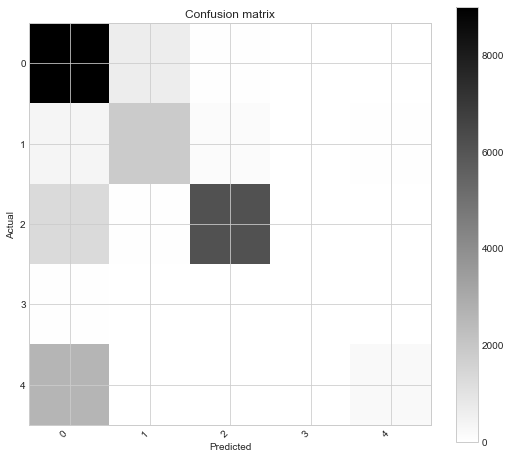

In [171]:
cm_knn.plot()

## Appendix

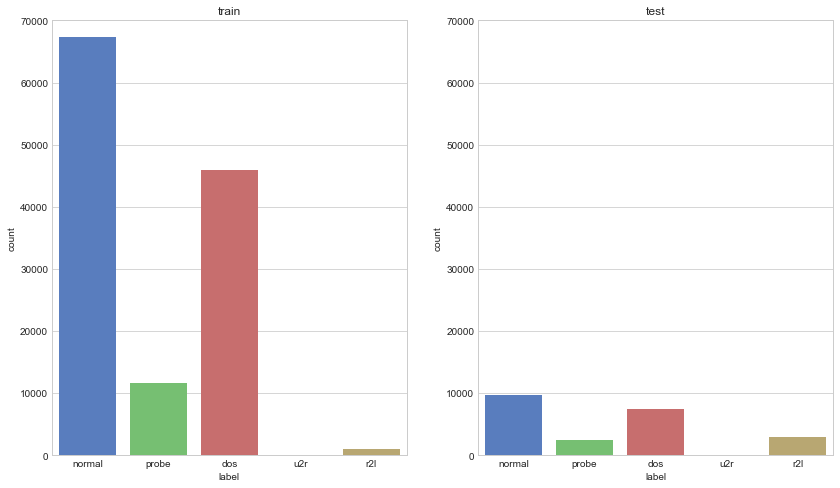

In [172]:
fig = plt.figure(figsize=(14,8))

ax1 = fig.add_subplot(121)
ax1.set_ylim([0,70000])
ax1.set_title('train')
sns.countplot(x='label', data=pd.DataFrame(train.label.apply(type_category), columns=['label']), 
              order=['normal', 'probe', 'dos', 'u2r', 'r2l'], ax=ax1, palette='muted')


ax2 = fig.add_subplot(122)
ax2.set_ylim([0,70000])
ax2.set_title('test')
sns.countplot(x='label', data=pd.DataFrame(test.label.apply(type_category), columns=['label']), 
              order=['normal', 'probe', 'dos', 'u2r', 'r2l'], ax=ax2, palette='muted')